In [5]:
import numpy as np
import pandas as pd

from scipy import stats
from scipy.optimize import brute

%matplotlib inline 

# Question 1
## Part A

In [73]:
def absolute_error(args):
    rate, = args
    return np.abs(0.5 - stats.gamma.cdf(x=75, a=100*(rate**2), scale=1/rate)),

In [77]:
b_prior = brute(absolute_error,
                ranges=(slice(0.01, 0.8, 0.001), ),
                finish=None)
a_prior = 100 * b_prior ** 2
a_prior, b_prior

(56.851599999999905, 0.7539999999999993)

In [83]:
stats.gamma(a=a_prior, scale=1/b_prior).cdf(x=75)

0.5016659037469644

<AxesSubplot:>

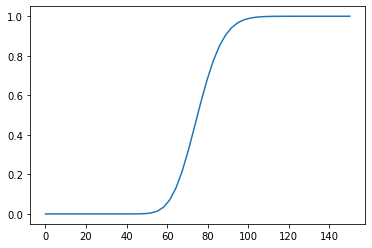

In [85]:
pd.Series({
    x: stats.gamma(a=a_prior, scale=1/b_prior).cdf(x)
    for x in np.linspace(0, 150)}).plot()

## Part B

Text(0.5, 1.0, 'Posterior $Pr(theta > 75| k)$ ')

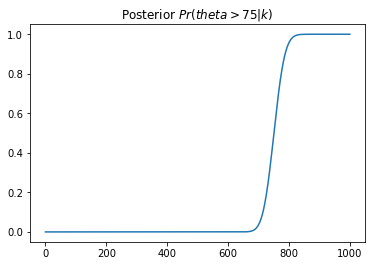

In [107]:
pd.Series({
    k: 1 - posterior_cdf_x_k(x=75, k=k, a_prior=a_prior, b_prior=b_prior, n=10)
    for k in range(1000)
}).plot().set_title("Posterior $Pr(theta > 75| k)$ ")›

In [105]:
def posterior_cdf_x_k(x, k, a_prior, b_prior, n):
    posterior_a = a_prior + k
    posterior_scale = 1 / (b_prior + n)
    return stats.gamma(a=posterior_a, scale=posterior_scale).cdf(x)

brute(lambda args: 0.95 - (1 - posterior_cdf_x_k(x=75, k=args[0], a_prior=a_prior, b_prior=b_prior, n=10)), 
      ranges=(slice(0, 1000, 1), ),
      finish=None)



997.0

# Problem 2


In [126]:
def posterior_scaled_inv_chi_2_cdf(x, prior_v, n, prior_sigma_2, observed_var):
    """Return the $Pr(\sigma^2 > x | y, v_0, \sigma^2_0"""
    v = prior_v + n
    s_2 = (prior_v * prior_sigma_2 + n * observed_var) / v
    return stats.chi2(v).cdf(v*s_2/ x)

In [133]:
results = []
for prior_v in {0, 1}:
    for x in {1, 2}:
        results.append({
            "prior_v": prior_v,
            "s": x,
            "prob(sigma > s | prior_v, y)": posterior_scaled_inv_chi_2_cdf(x**2, prior_v, n=20, prior_sigma_2=1, observed_var=15./20)
        })

In [134]:
pd.DataFrame(results).pivot(index='prior_v', columns='s')

prob(sigma > s | prior_v, y)          
s                                  1         2
prior_v                                       
0                           0.223592  0.000027
1                           0.230349  0.000020

# Problem 3

In [194]:
import seaborn as sns
sns.set()

/Users/rahul/opt/miniconda3/envs/bayes/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


<AxesSubplot:>

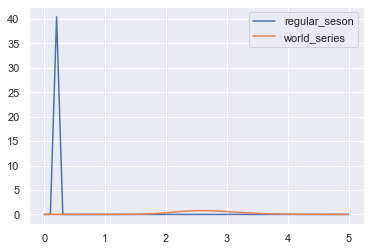

In [195]:
epsilon = 0.001
pd.DataFrame(
    {"regular_seson": pd.Series({x: stats.gamma(563 + epsilon, scale=1/(2820 + epsilon)).pdf(x) for x in np.linspace(0, 5)}),
     "world_series": pd.Series({x: stats.gamma(27 + epsilon, scale=1/(10 + epsilon)).pdf(x) for x in np.linspace(0, 5)})}).plot()

In [192]:
alpha_0 = 563
beta_0 = 2820
alpha_1 = 27
beta_1 = 10

In [193]:
1 - stats.f(2 * alpha_1, 2 * alpha_0).cdf(alpha_0 * beta_1 / (alpha_1 * beta_0))

1.0

# Problem 4


In [196]:
data = pd.DataFrame({
    "placebo": [2, -3.1, -1.0, 0.2, 0.3, 0.4],
    "treatment": [-3.5, -1.6, -4.6, -0.9, -5.1, 0.1],
})

In [197]:
data

placebo  treatment
0      2.0       -3.5
1     -3.1       -1.6
2     -1.0       -4.6
3      0.2       -0.9
4      0.3       -5.1
5      0.4        0.1

## Part A

In [207]:
data.placebo.mean()

-0.20000000000000004

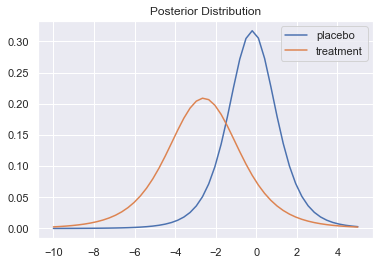

In [220]:
def posterior_t(series):
    n = len(series)
    loc = series.mean()
    scale = series.var(ddof=1) / np.sqrt(n)
    return stats.t(n - 1, loc=loc, scale=scale)

def posterior_series(series):
    return pd.Series({
        x: posterior_t(series).pdf(x)
        for x in np.linspace(-10, 5)
    })

pd.DataFrame({
    "placebo": posterior_series(data.placebo),
    "treatment": posterior_series(data.treatment),
}).plot().set_title("Posterior Distribution");

## Part B

In [235]:
SAMPLES = 10000
np.mean(posterior_t(data.treatment).rvs(SAMPLES) < posterior_t(data.placebo).rvs(SAMPLES))

0.8254

## Part C

In [241]:
mu_samples

In [252]:
def get_ppd_for(series):
    SAMPLES = 1000
    n = len(series)
    mu_n = series.mean()
    s_2 = series.var(ddof=1)
    sigma_2_samples = (n - 1) * s_2 / stats.chi2(n-1).rvs(SAMPLES)
    mu_samples = [stats.norm(mu_n, sigma_2_sample / n).rvs(1)[0] for sigma_2_sample in sigma_2_samples]
    ppd = [
        stats.norm(mu, sigma_2).rvs(1)[0] for mu, sigma_2 in zip(mu_samples, sigma_2_samples)
    ]
    return ppd


(-20.0, 20.0)

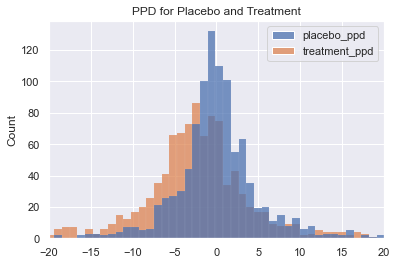

In [267]:
ppd = pd.DataFrame({
        "placebo_ppd": get_ppd_for(data.placebo),
        "treatment_ppd": get_ppd_for(data.treatment),
    })
ax = sns.histplot(data=ppd)
ax.set_title("PPD for Placebo and Treatment")
ax.set_xlim(-20, 20)

In [268]:
(ppd['treatment_ppd'] < ppd['placebo_ppd']).mean()

0.646